# LLaVa Experiment

## Configuration

### Load YAML

In [3]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import *
import yaml
import torch
import numpy as np
import random
import os

def load_config(config_path,config_name):
    with open(os.path.join(config_path, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("./","config.yaml")

FileNotFoundError: [Errno 2] No such file or directory: './config.yaml'

### Initialize Params

In [80]:
# Constants & Seed
SEED = config["seed"]
torch.manual_seed(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

# Inputs
IMG_PATH = config["image_path"]
IMG_ID = IMG_PATH.split('/')[-1].split('.')[0]

# Prompt
LR_PROMPT_TYPE = config['prompt']['lr']['filename']
QG_PROMPT_TYPE = config["prompt"]["qg"]["filename"]
LR_PROMPT_PATH = f"{config['prompt']['lr']['parent']}{LR_PROMPT_TYPE}.txt"
QG_PROMPT_PATH = f'{config["prompt"]["qg"]["parent"]}{QG_PROMPT_TYPE}.txt'
with open(LR_PROMPT_PATH, "r") as file:
    LR_PROMPT= file.read()
with open(QG_PROMPT_PATH,"r") as file:
    QG_PROMPT = file.read()

# Params
MODEL_PATH = config["llava"]["model_path"]
PAIR_NUM = config["llava"]["params"]["pair_count"]

# Result
LR_RESULT_PARENT_PATH = config["result"]["llava"]["lr_path"]
QG_RESULT_PARENT_PATH = config["result"]["llava"]["qg_path"]
JSON_PARENT_PATH = config["result"]["llava"]["json_path"]

## Experiment

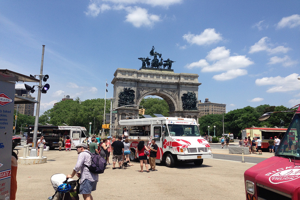

In [81]:
display(load_image(IMG_PATH).resize((300,200)))

### List-then-Rewrite

In [82]:
lr_args = type('Args', (), {
 "model_path": MODEL_PATH,
 "model_base": model_base,
 "model_name": get_model_name_from_path(MODEL_PATH),
 "query": LR_PROMPT.format(number = PAIR_NUM),
 "conv_mode": None,
 "image_file": IMG_PATH
})()
lr_output = eval_model(lr_args)

print(lr_output)

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


1. A group of people are gathered around a food truck, with some of them standing in line to order food.
2. A man is pushing a stroller, with a child sitting in it.
3. A woman is walking with a backpack, likely carrying her belongings.
4. A person is riding a bicycle, passing by the food truck.
5. A person is holding a cell phone, possibly checking messages or taking a photo.
6. A person is wearing a backpack, possibly carrying their belongings.
7. A person is wearing a hat, possibly for sun protection.
8. A person is wearing a shirt, possibly indicating their profession or personal preference.
9. A person is wearing a tie, possibly indicating a formal occasion or their profession.
10. A person is wearing a necklace, possibly as a fashion accessory or personal statement.


### Question Generation

In [83]:
qg_args = type('Args', (), {
 "model_path": MODEL_PATH,
 "model_base": model_base,
 "model_name": get_model_name_from_path(MODEL_PATH),
 "query": QG_PROMPT.format(desc = lr_output, number = PAIR_NUM),
 "conv_mode": None,
 "image_file": IMG_PATH
})()
qg_output = eval_model(qg_args)

print(qg_output)

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.03s/it]


1. What is the purpose of the gathering around the food truck?
S. People are ordering food.
L. People are gathering around the food truck to order food, which is a popular and convenient way to enjoy a meal on the go.
2. Where is the man pushing the stroller?
S. In front of the food truck.
L. The man is pushing the stroller in front of the food truck, likely to ensure the child's safety while he orders food.
3. Where is the woman walking with her backpack?
S. In front of the food truck.
L. The woman is walking with her backpack in front of the food truck, possibly on her way to a nearby destination.
4. Where is the person riding the bicycle?
S. In front of the food truck.
L. The person is riding the bicycle in front of the food truck, likely as a mode of transportation to the truck or to another destination.
5. Where is the person holding a cell phone?
S. In front of the food truck.
L. The person is holding a cell phone in front of the food truck, possibly checking messages, browsing t

## Result

### Export `.txt` file

In [84]:
LR_RESULT_FILENAME = f"LLaVa_LR_N_result_{IMG_ID}.txt" 
QG_RESULT_FILENAME = f"LLaVa_QG_N_result_{IMG_ID}.txt" 
LR_RESULT_PATH = LR_RESULT_PARENT_PATH + LR_RESULT_FILENAME
QG_RESULT_PATH = QG_RESULT_PARENT_PATH + QG_RESULT_FILENAME

with open(LR_RESULT_PATH, "w") as file:
    file.write(lr_output)

with open(QG_RESULT_PATH, "w") as file:
    file.write(qg_output)

### Export `.json` file

In [86]:
import re
import json

JSON_PATH = JSON_PARENT_PATH + f"LLaVa_{QG_PROMPT_TYPE}_{IMG_ID}.json"

def extract_data(img_id, lr_result_path, qg_result_path, output_json_path = JSON_PATH):
    # Extract lr descriptions
    descriptions = []
    current_description = None

    with open(lr_result_path, 'r') as file:
        text = file.read()

    for line in text.split('\n'):
        if (match := re.match(r'^(\d+)\. (.+)$', line)):
            current_description = match.group(2)

        if current_description:
            descriptions.append(current_description)
            current_description = None
    
    
    # Extract QAs result
    questions, short_answers, reasoned_answers = [], [], []
    current_question, current_short_answer, current_reasoned_answer = None, None, None

    with open(qg_result_path, 'r') as file:
        text = file.read()

    for line in text.split('\n'):
        if (match := re.match(r'^(\d+)\. (.+)$', line)):
            current_question = match.group(2)
        elif (match := re.match(r'^S\. (.+)$', line)):
            current_short_answer = match.group(1)
        elif (match := re.match(r'^L\. (.+)$', line)):
            current_reasoned_answer = match.group(1)

        if current_question and current_short_answer and current_reasoned_answer:
            questions.append(current_question)
            short_answers.append(current_short_answer)
            reasoned_answers.append(current_reasoned_answer)
            current_question, current_short_answer, current_reasoned_answer = None, None, None
    
    
    # Combine all pieces
    num = [i for i in range(PAIR_NUM)]
    data = [{"id": f"{img_id}_{n}", "description": d, "question": q, "short_answer": sa, "reasoned_answer": ra} for n, d, q, sa, ra in zip(num, descriptions, questions, short_answers, reasoned_answers)]
    
    with open(output_json_path, 'w') as json_file:
        json.dump(data, json_file, indent=2)

extract_data(
    img_id = IMG_ID,
    lr_result_path = LR_RESULT_PATH,
    qg_result_path = QG_RESULT_PATH
)

In [90]:
display("hellow")

'hellow'